In [1]:
import torch
import torchphysics as tp
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')
URMS = tp.spaces.R1('urms')
VRMS = tp.spaces.R1('vrms')
UV=tp.spaces.R1('uv')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

In [3]:
class Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        P_xtrain=tp.spaces.Points([self.x_train[idx]],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([self.y_train[idx]],U*V*URMS*VRMS*UV,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [4]:
DF_Data=pd.read_csv("Data/Flat_Turb_500.csv")

In [5]:
dataset_turbulent=Turbulent_Data(DF_Data,["x","y"],["U","V","urms","vrms","uv"])

In [6]:
torch.cuda.device_count()

1

In [7]:
X_interval = tp.domains.Interval(X, 0, 2.0) # <-add the bounds of the Interval (0, 2)
Y_interval = tp.domains.Interval(Y, 0, 2.0)
Sim_domain = X_interval*Y_interval


In [8]:

bound_sampler_low = tp.samplers.RandomUniformSampler(Y_interval.boundary_left*X_interval, n_points=250)

bound_sampler_up = tp.samplers.RandomUniformSampler(X_interval*Y_interval.boundary, n_points=1000)


In [9]:
def IBM_filter(y):
    return y[...,0]<0.4
    
IBM_sampler = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter)

In [10]:
def IBM_filter_2(y):
    return (y[...,0]<0.4)&(y[...,0]>0.3)
    
IBM_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter_2)

In [11]:
def Inner_filter(y):
    return y[...,0]>=0.4

inner_sampler = tp.samplers.RandomUniformSampler(Sim_domain, n_points=8000)#,filter_fn=Inner_filter)

In [12]:
model = tp.models.FCN(input_space=X*Y, output_space=U*V*URMS*VRMS*UV, hidden=(90,80,70,60,50,50))#######Activation????

In [13]:
data_cond = tp.conditions.DataCondition(model, dataset_turbulent, norm=2.0,root=1.0,weight=500,use_full_dataset=True,name='Data')

In [14]:
inte_sampler = tp.samplers.RandomUniformSampler(X_interval.boundary*Y_interval, n_points=250)
x_inlet_sampler=tp.samplers.RandomUniformSampler(X_interval*Y_interval,n_points=250)

In [15]:
def init_bulk(u_integral):
    return u_integral-1
pde_cond_bulk=tp.conditions.IntegroPINNCondition(model,x_inlet_sampler,init_bulk,inte_sampler, weight=1)

In [16]:
def pde_IBM(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM = tp.conditions.PINNCondition(model, IBM_sampler, pde_IBM,weight=10,name='IBM')

In [17]:
def pde_IBM_2(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM_2 = tp.conditions.PINNCondition(model, IBM_sampler_2, pde_IBM_2,weight=10,name='IBM_2')

In [18]:
def pde_mass(u,v,x,y):
    return tp.utils.grad(u,x)+tp.utils.grad(v,y)-0.0
pde_cond_mass = tp.conditions.PINNCondition(model, inner_sampler,pde_mass, weight=1,name='Conti')

In [19]:
def pde_residual_x(u,v, x, y,urms,vrms,uv):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/6000 + (1/12)**2+tp.utils.grad(torch.square(urms),x)+tp.utils.grad(uv,y)
    return residual_momentum

pde_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_x, pde_IBM,weight=50,name='Momentum_x')

In [20]:
def pde_residual_y(u,v, x, y,urms,vrms,uv):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/6000+tp.utils.grad(uv,x)+tp.utils.grad(torch.square(vrms),y)
    return residual_momentum

pde_cond_y = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_y, pde_IBM,weight=30,name='Momentum_y')

In [21]:
def boundary_residual_x(u, x,y):
    return torch.square(u) - 0.0

boundary_cond_x = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_x, weight=100,name='noslip_x')

In [22]:
def boundary_residual_y(v, x,y):
    return torch.square(v) - 0.0

boundary_cond_y = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_y, weight=100,name='noslip_y')

In [23]:
def boundary_residual_uu(urms, x,y):
    return torch.square(urms) - 0.0

boundary_cond_uu = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_uu, weight=100,name='noslip_x_uu')

In [24]:
def boundary_residual_vv(vrms, x,y):
    return torch.square(vrms) - 0.0

boundary_cond_vv = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_vv, weight=100,name='noslip_x_vv')

In [25]:
def boundary_residual_uv(uv, x,y):
    return uv - 0.0

boundary_cond_uv = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_uv, weight=100,name='noslip_x_uv')

In [26]:

Periodic_sampler=tp.samplers.RandomUniformSampler(Y_interval,n_points=1000)#,filter_fn=Inner_filter)

In [27]:
def periodic_residual_x(u_left,u_right):
    Periodic_condition= u_left - u_right
    return Periodic_condition
periodic_cond_x=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_x,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_x')

In [28]:
def periodic_residual_y(v_left,v_right):
    Periodic_condition= v_left - v_right
    return Periodic_condition
periodic_cond_y=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_y,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_y')

In [29]:
def periodic_residual_uu(urms_left,urms_right):
    Periodic_condition= urms_left - urms_right
    return Periodic_condition
periodic_cond_uu=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_uu,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_uu')

In [30]:
def periodic_residual_vv(vrms_left,vrms_right):
    Periodic_condition= vrms_left - vrms_right
    return Periodic_condition
periodic_cond_vv=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_vv,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_vv')

In [31]:
def periodic_residual_uv(uv_left,uv_right):
    Periodic_condition= uv_left - uv_right
    return Periodic_condition
periodic_cond_uv=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_uv,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_uv')

In [32]:
##Learning rate scheduling To-Do -- launch LR scheduling only after first training phase
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001,scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,scheduler_args={"patience":1000,"factor":0.8,"verbose":True,"min_lr":0.000005},monitor_lr="train/loss")
#solver = tp.solver.Solver([pde_cond_IBM,pde_cond_mass,boundary_cond_x, pde_cond_x,periodic_cond_x,boundary_cond_y, pde_cond_y,periodic_cond_y], optimizer_setting=optim)
##loss terms scheduling
solver = tp.solver.Solver([#pde_cond_IBM,#1000
                           #pde_cond_IBM_2,#1000
                            data_cond,
                           boundary_cond_x,#1000
                           boundary_cond_y,
                           boundary_cond_uu,#1000
                           boundary_cond_vv,
                           boundary_cond_uv,
                           periodic_cond_x,#2000
                           periodic_cond_y,
                           periodic_cond_uu,#2000
                           periodic_cond_vv,
                           periodic_cond_uv,
                           pde_cond_x,#5000
                           pde_cond_y,#5000
                           pde_cond_mass],#1000
                          optimizer_setting=optim,
                         loss_function_schedule=[{
                        "conditions":list(range(14)),
                        "max_iter":50000
                    },
                     {
                        "conditions":[0,1,2,3,4,5],
                        "max_iter":10000
                    }
                ],
                          weight_tunning=True,
                          weight_tunning_parameters={
                                    "alfa":0.99,
                                    "E_rho":0.99,
                                    "Temperature":0.1,
                                    "tunning_every_n_steps":100
                          } ## Default weight-tunning settings
                         )

In [33]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
torch.set_float32_matmul_precision('medium')
comet_logger = pl_loggers.CSVLogger(save_dir="logs/")
trainer = pl.Trainer(gpus=0,# use one GPU
                     max_steps=20000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=comet_logger, # for writting into tensorboard
                     log_every_n_steps=100,
                     enable_checkpointing=False) # saving checkpoints ToDo: turn on checkpointing after first training phase
trainer.fit(solver)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:273: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'min_lr', 'patience', 'factor', 'verbose'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name             | Type       | Params
---------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                                                | 0/20001 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchphysics/problem/spaces/points.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self._t = torch.as_tensor(data, **kwargs)


Epoch 0: 100%|██████████████████████████████████████████▉| 20000/20001 [3:44:44<00:00,  1.48it/s, loss=0.0056, v_num=51]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████| 20001/20001 [3:44:44<00:00,  1.48it/s, loss=0.0056, v_num=51]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|███████████████████████████████████████████| 20001/20001 [3:44:44<00:00,  1.48it/s, loss=0.0056, v_num=51]


In [34]:
import numpy as np

In [35]:
import matplotlib.pyplot as plt

In [36]:
plt.close()

In [46]:
def produce_sample(x_max,y_max,other_Constrains,resolution=100):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(0,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)    
    model_value_urms=np.zeros(XM.shape)

    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j]]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,1]
            model_value_urms[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,2]
    plt.contourf(XM,YM,model_value_urms)
    plt.colorbar()
    plt.plot([0.4,0.4],[0,2])
    return model_value_x


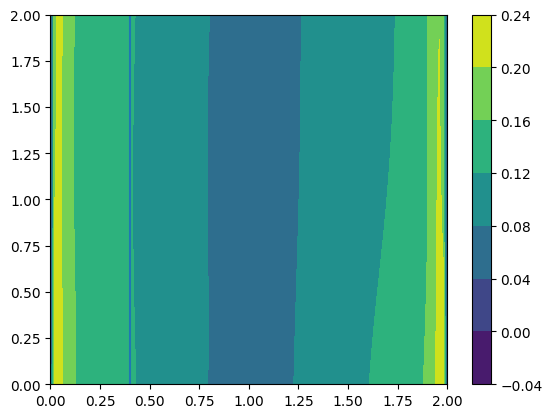

In [47]:
model_values=produce_sample(2,2,500)


In [ ]:
model_values=produce_sample(2,2,100)


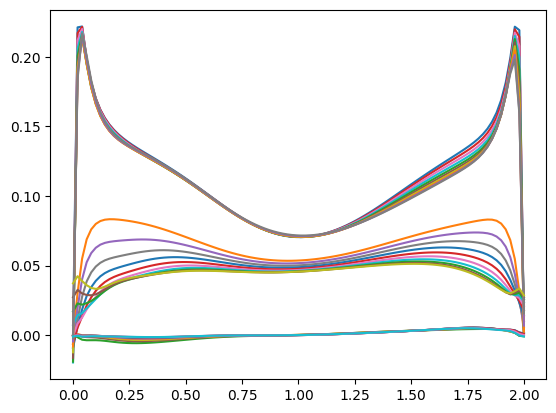

In [50]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
    for k in range(2,5):
        plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

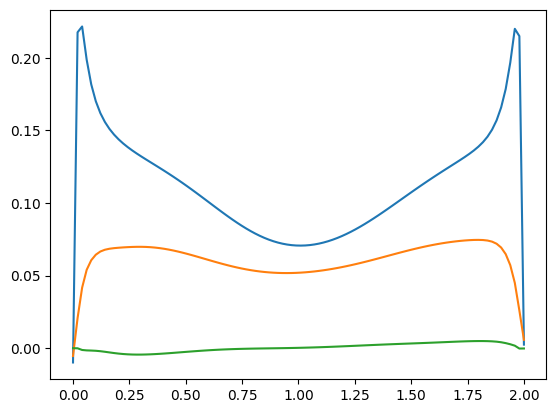

In [55]:
coords = torch.tensor([[0.2,i] for i in np.linspace(0,2,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(2,5):
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

In [ ]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,20] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

In [ ]:
coords = torch.tensor([[5,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))
coords = torch.tensor([[0,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))